## Process test ground truth for evaluation

In [1]:
from os import path, listdir, rename
# import subprocess
 
def rename_gt_1(gt_path):
    for file_name in listdir(gt_path):
        if "gt_" not in file_name:
            file_path = path.join(gt_path, file_name)
            new_file_name = "gt_" + file_name
            new_file_path = path.join(gt_path, new_file_name)
            rename(file_path, new_file_path)

In [2]:
def rename_gt_2(gt_path):
    for file_name in listdir(gt_path):
        file_path = path.join(gt_path, file_name)
        file_name = file_name.split("_")[-1]

        zeros = "0" * (8 - len(file_name))

        new_file_name = "gt_im" + zeros + file_name
        new_file_path = path.join(gt_path, new_file_name)
        rename(file_path, new_file_path)

In [3]:
def rename_gt_3(gt_path):
    for file_name in listdir(gt_path):
        file_path = path.join(gt_path, file_name)
        if "gt_" in file_name:
            new_file_name = file_name[3:]
        else:
            new_file_name = file_name
            
        new_file_path = path.join(gt_path, new_file_name)
        rename(file_path, new_file_path)

In [5]:
train_gt_path = "/mnt/data/src/EAST/data/test/test_gt"
rename_gt_3(train_gt_path)

In [15]:
train_gt_path = "/mnt/data/src/text_detection/data_cook/train_gt"
test_gt_path = "/mnt/data/src/text_detection/data_cook/test_gt"

rename_gt_1(train_gt_path)
rename_gt_1(test_gt_path)

In [18]:
import os

img_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/train_img"
gt_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/train_gt"

imgs = [x.split(".")[0] for x in os.listdir(img_path)]
gts = [x.split(".")[0] for x in os.listdir(gt_path)]

len(imgs), len(gts)

(4725, 4725)

In [20]:
test_img_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/test_img"
test_gt_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/test_gt"

test_imgs = [x.split(".")[0] for x in os.listdir(test_img_path)]
test_gts = [x.split(".")[0] for x in os.listdir(test_gt_path)]

len(test_imgs), len(test_gts)

(1500, 1500)

In [11]:
redundant_imgs = [x for x in imgs if x not in gts]
redundant_imgs

['1698549704027_4',
 '1699678113962_3_POI',
 '1700297942343_1_PA',
 '1720590006319_0',
 '17211947176782',
 '17212823922968']

In [12]:
def get_path_from_id(id: str, folder_path: str) -> str:
    file_name = id + ".jpg"
    return os.path.join(folder_path, file_name)

def remove_images(image_paths: list[str]) -> None:
    for image_path in image_paths:
        os.remove(image_path)
    
    print("Removed {} redundant images".format(len(image_paths)))

In [13]:
redundant_img_paths = [get_path_from_id(x, img_path) for x in redundant_imgs]
remove_images(redundant_img_paths)

Removed 6 redundant images


In [16]:
import os
import shutil
import random


def move_images_and_gts(image_folder, text_folder, dest_image_folder, dest_text_folder, num_to_move):
    os.makedirs(dest_image_folder, exist_ok=True)
    os.makedirs(dest_text_folder, exist_ok=True)

    # List all image and text files
    image_files = os.listdir(image_folder)
    text_files = os.listdir(text_folder)

    # Pair files by their base name (without extensions)
    file_pairs = [(img, txt) for img in image_files for txt in text_files if os.path.splitext(img)[0] == os.path.splitext(txt)[0]]

    # Shuffle and select a subset (e.g., 1000 pairs)
    random.shuffle(file_pairs)
    selected_pairs = file_pairs[:num_to_move]

    # Move the selected pairs to the destination folders
    for img, txt in selected_pairs:
        shutil.move(os.path.join(image_folder, img), os.path.join(dest_image_folder, img))
        shutil.move(os.path.join(text_folder, txt), os.path.join(dest_text_folder, txt))

In [17]:
test_img_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/test_img"
test_gt_path = "/mnt/data/data/Data_Ve_Chu/Data_Ve_Chu_copy/test_gt"

move_images_and_gts(img_path, gt_path, test_img_path, test_gt_path, 1500)

# dataset.py

In [ ]:
from shapely.geometry import Polygon
import numpy as np
import cv2
from PIL import Image
import math
import os
import torch
import torchvision.transforms as transforms
from torch.utils import data


def cal_distance(x1, y1, x2, y2):
    """calculate the Euclidean distance"""
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def move_points(vertices, index1, index2, r, coef):
    """move the two points to shrink edge
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
            index1  : offset of point1
            index2  : offset of point2
            r       : [r1, r2, r3, r4] in paper
            coef    : shrink ratio in paper
    Output:
            vertices: vertices where one edge has been shinked
    """
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(
        vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index]
    )
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x)
        vertices[y1_index] += ratio * (-length_y)
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x
        vertices[y2_index] += ratio * length_y
    return vertices


def shrink_poly(vertices, coef=0.3):
    """shrink the text region
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
            coef    : shrink ratio in paper
    Output:
            v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    """
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1, y1, x2, y2), cal_distance(x1, y1, x4, y4))
    r2 = min(cal_distance(x2, y2, x1, y1), cal_distance(x2, y2, x3, y3))
    r3 = min(cal_distance(x3, y3, x2, y2), cal_distance(x3, y3, x4, y4))
    r4 = min(cal_distance(x4, y4, x1, y1), cal_distance(x4, y4, x3, y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1, y1, x2, y2) + cal_distance(x3, y3, x4, y4) > cal_distance(
        x2, y2, x3, y3
    ) + cal_distance(x1, y1, x4, y4):
        offset = 0  # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1  # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v


def get_rotate_mat(theta):
    """positive theta value means rotate clockwise"""
    return np.array(
        [[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]
    )


def rotate_vertices(vertices, theta, anchor=None):
    """rotate vertices around anchor
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
            theta   : angle in radian measure
            anchor  : fixed position during rotation
    Output:
            rotated vertices <numpy.ndarray, (8,)>
    """
    v = vertices.reshape((4, 2)).T
    if anchor is None:
        anchor = v[:, :1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)


def get_boundary(vertices):
    """get the tight boundary around given vertices
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
            the boundary
    """
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max


def cal_error(vertices):
    """default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
            err     : difference measure
    """
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = (
        cal_distance(x1, y1, x_min, y_min)
        + cal_distance(x2, y2, x_max, y_min)
        + cal_distance(x3, y3, x_max, y_max)
        + cal_distance(x4, y4, x_min, y_max)
    )
    return err


def find_min_rect_angle(vertices):
    """find the best angle to rotate poly and obtain min rectangle
    Input:
            vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
            the best angle <radian measure>
    """
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * (
            max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
        )
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float("inf")
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi


def is_cross_text(start_loc, length, vertices):
    """check if the crop image crosses text regions
    Input:
            start_loc: left-top position
            length   : length of crop image
            vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
            True if crop image crosses text region
    """
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array(
        [
            start_w,
            start_h,
            start_w + length,
            start_h,
            start_w + length,
            start_h + length,
            start_w,
            start_h + length,
        ]
    ).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False


def crop_img(img, vertices, labels, length):
    """crop img patches to obtain batch and augment
    Input:
            img         : PIL Image
            vertices    : vertices of text regions <numpy.ndarray, (n,8)>
            labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
            length      : length of cropped image region
    Output:
            region      : cropped image region
            new_vertices: new vertices in cropped region
    """
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert ratio_w >= 1 and ratio_h >= 1

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:, [0, 2, 4, 6]] = vertices[:, [0, 2, 4, 6]] * ratio_w
        new_vertices[:, [1, 3, 5, 7]] = vertices[:, [1, 3, 5, 7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels == 1, :])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:, [0, 2, 4, 6]] -= start_w
    new_vertices[:, [1, 3, 5, 7]] -= start_h
    return region, new_vertices


def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    """get rotated locations of all pixels for next stages
    Input:
            rotate_mat: rotatation matrix
            anchor_x  : fixed x position
            anchor_y  : fixed y position
            length    : length of image
    Output:
            rotated_x : rotated x positions <numpy.ndarray, (length,length)>
            rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    """
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(
        rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])
    ) + np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


def adjust_height(img, vertices, ratio=0.2):
    """adjust height of image to aug data
    Input:
            img         : PIL Image
            vertices    : vertices of text regions <numpy.ndarray, (n,8)>
            ratio       : height changes in [0.8, 1.2]
    Output:
            img         : adjusted PIL Image
            new_vertices: adjusted vertices
    """
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:, [1, 3, 5, 7]] = vertices[:, [1, 3, 5, 7]] * (new_h / old_h)
    return img, new_vertices


def rotate_img(img, vertices, angle_range=10):
    """rotate image [-10, 10] degree to aug data
    Input:
            img         : PIL Image
            vertices    : vertices of text regions <numpy.ndarray, (n,8)>
            angle_range : rotate range
    Output:
            img         : rotated PIL Image
            new_vertices: rotated vertices
    """
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i, :] = rotate_vertices(
            vertice, -angle / 180 * math.pi, np.array([[center_x], [center_y]])
        )
    return img, new_vertices


def get_score_geo(img, vertices, labels, scale, length):
    """generate score gt and geometry gt
    Input:
            img     : PIL Image
            vertices: vertices of text regions <numpy.ndarray, (n,8)>
            labels  : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
            scale   : feature map / image
            length  : image length
    Output:
            score gt, geo gt, ignored
    """
    score_map = np.zeros(
        (int(img.height * scale), int(img.width * scale), 1), np.float32
    )
    geo_map = np.zeros((int(img.height * scale), int(img.width * scale), 5), np.float32)
    ignored_map = np.zeros(
        (int(img.height * scale), int(img.width * scale), 1), np.float32
    )

    index = np.arange(0, length, int(1 / scale))
    index_x, index_y = np.meshgrid(index, index)
    ignored_polys = []
    polys = []

    for i, vertice in enumerate(vertices):
        if labels[i] == 0:
            ignored_polys.append(
                np.around(scale * vertice.reshape((4, 2))).astype(np.int32)
            )
            continue

        poly = np.around(scale * shrink_poly(vertice).reshape((4, 2))).astype(
            np.int32
        )  # scaled & shrinked
        polys.append(poly)
        temp_mask = np.zeros(score_map.shape[:-1], np.float32)
        cv2.fillPoly(temp_mask, [poly], 1)

        theta = find_min_rect_angle(vertice)
        rotate_mat = get_rotate_mat(theta)

        rotated_vertices = rotate_vertices(vertice, theta)
        x_min, x_max, y_min, y_max = get_boundary(rotated_vertices)
        rotated_x, rotated_y = rotate_all_pixels(
            rotate_mat, vertice[0], vertice[1], length
        )

        d1 = rotated_y - y_min
        d1[d1 < 0] = 0
        d2 = y_max - rotated_y
        d2[d2 < 0] = 0
        d3 = rotated_x - x_min
        d3[d3 < 0] = 0
        d4 = x_max - rotated_x
        d4[d4 < 0] = 0
        geo_map[:, :, 0] += d1[index_y, index_x] * temp_mask
        geo_map[:, :, 1] += d2[index_y, index_x] * temp_mask
        geo_map[:, :, 2] += d3[index_y, index_x] * temp_mask
        geo_map[:, :, 3] += d4[index_y, index_x] * temp_mask
        geo_map[:, :, 4] += theta * temp_mask

    cv2.fillPoly(ignored_map, ignored_polys, 1)
    cv2.fillPoly(score_map, polys, 1)
    return (
        torch.Tensor(score_map).permute(2, 0, 1),
        torch.Tensor(geo_map).permute(2, 0, 1),
        torch.Tensor(ignored_map).permute(2, 0, 1),
    )


def extract_vertices(lines):
    """extract vertices info from txt lines
    Input:
            lines   : list of string info
    Output:
            vertices: vertices of text regions <numpy.ndarray, (n,8)>
            labels  : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
    """
    labels = []
    vertices = []
    for line in lines:
        vertices.append(
            list(map(int, line.rstrip("\n").lstrip("\ufeff").split(",")[:8]))
        )
        label = 0 if "###" in line else 1
        labels.append(label)
    return np.array(vertices), np.array(labels)


class custom_dataset(data.Dataset):
    def __init__(self, img_path, gt_path, scale=0.25, length=512):
        super(custom_dataset, self).__init__()
        self.img_files = [
            os.path.join(img_path, img_file)
            for img_file in sorted(os.listdir(img_path))
        ]
        self.gt_files = [
            os.path.join(gt_path, gt_file) for gt_file in sorted(os.listdir(gt_path))
        ]

        assert len(self.img_files) == len(self.gt_files)

        self.scale = scale
        self.length = length

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        try:
            with open(self.gt_files[index], "r") as f:
                lines = f.readlines()
            vertices, labels = extract_vertices(lines)

            img = Image.open(self.img_files[index])
            img = img.convert("RGB")
            img, vertices = adjust_height(img, vertices)
            img, vertices = rotate_img(img, vertices)
            img, vertices = crop_img(img, vertices, labels, self.length)
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.ColorJitter(0.5, 0.5, 0.5, 0.25),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                ]
            )

            trf_img = transform(img)
            score_map, geo_map, ignored_map = get_score_geo(
                img, vertices, labels, self.scale, self.length
            )
            return trf_img, score_map, geo_map, ignored_map
        except:
            raise Exception(f"Error at {index}")

# process vinai-labels

In [ ]:
import os


def count_files(directory: str) -> int:
    return len(os.listdir(directory))

In [ ]:
# labels = count_files('/mnt/data1/src/ocr/vinai-vietnamese/labels')
# train = count_files('/mnt/data1/src/ocr/vinai-vietnamese/train_img')
# test = count_files('/mnt/data1/src/ocr/vinai-vietnamese/test_img')

# print(train, test)

## split labels into train and test

In [ ]:
# labels_dir = '/mnt/data1/src/ocr/vinai-vietnamese/labels'
# train_imgs_dir = '/mnt/data1/src/ocr/vinai-vietnamese/train_img'
# test_imgs_dir = '/mnt/data1/src/ocr/vinai-vietnamese/test_img'

In [ ]:
# labels = os.listdir(labels_dir)
# train_imgs = os.listdir(train_imgs_dir)
# test_imgs = os.listdir(test_imgs_dir)

In [ ]:
# print(labels[0], train_imgs[0], test_imgs[0])

In [ ]:
def get_id_from_image(image_path: str) -> str:
    name = image_path.split(".")[0]
    name = name[2:]

    return int(name)


def get_id_from_label(label_path: str) -> str:
    name = label_path.split(".")[0]
    name = name.split("_")[-1]

    return int(name)

In [ ]:
# train_ids = [get_id_from_image(train_img) for train_img in train_imgs]
# test_ids = [get_id_from_image(test_img) for test_img in test_imgs]

In [ ]:
# train_ids[0], test_ids[0]

In [ ]:
# import shutil

# train_labels_dir = '/mnt/data1/src/ocr/vinai-vietnamese/train_gt'
# test_labels_dir = '/mnt/data1/src/ocr/vinai-vietnamese/test_gt'

# for label in labels:
#     id = get_id_from_label(label)
#     if id in train_ids:
#         shutil.copy(os.path.join(labels_dir, label), train_labels_dir)
#     if id in test_ids:
#         shutil.copy(os.path.join(labels_dir, label), test_labels_dir)

In [ ]:
train = count_files("/mnt/data1/src/ocr/vinai-vietnamese/train_gt")
test = count_files("/mnt/data1/src/ocr/vinai-vietnamese/test_gt")

print(train, test)

# model.py


In [ ]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import math

cfg = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    "M",
]


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class extractor(nn.Module):
    def __init__(self, pretrained):
        super(extractor, self).__init__()
        vgg16_bn = VGG(make_layers(cfg, batch_norm=True))
        if pretrained:
            vgg16_bn.load_state_dict(torch.load("./pths/vgg16_bn-6c64b313.pth"))
        self.features = vgg16_bn.features

    def forward(self, x):
        out = []
        for m in self.features:
            x = m(x)
            if isinstance(m, nn.MaxPool2d):
                out.append(x)
        return out[1:]


class merge(nn.Module):
    def __init__(self):
        super(merge, self).__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(384, 64, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(192, 32, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.relu6 = nn.ReLU()

        self.conv7 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.relu7 = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = F.interpolate(x[3], scale_factor=2, mode="bilinear", align_corners=True)
        y = torch.cat((y, x[2]), 1)
        y = self.relu1(self.bn1(self.conv1(y)))
        y = self.relu2(self.bn2(self.conv2(y)))

        y = F.interpolate(y, scale_factor=2, mode="bilinear", align_corners=True)
        y = torch.cat((y, x[1]), 1)
        y = self.relu3(self.bn3(self.conv3(y)))
        y = self.relu4(self.bn4(self.conv4(y)))

        y = F.interpolate(y, scale_factor=2, mode="bilinear", align_corners=True)
        y = torch.cat((y, x[0]), 1)
        y = self.relu5(self.bn5(self.conv5(y)))
        y = self.relu6(self.bn6(self.conv6(y)))

        y = self.relu7(self.bn7(self.conv7(y)))
        return y


class output(nn.Module):
    def __init__(self, scope=512):
        super(output, self).__init__()
        self.conv1 = nn.Conv2d(32, 1, 1)
        self.sigmoid1 = nn.Sigmoid()
        self.conv2 = nn.Conv2d(32, 4, 1)
        self.sigmoid2 = nn.Sigmoid()
        self.conv3 = nn.Conv2d(32, 1, 1)
        self.sigmoid3 = nn.Sigmoid()
        self.scope = 512
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        score = self.sigmoid1(self.conv1(x))
        loc = self.sigmoid2(self.conv2(x)) * self.scope
        angle = (self.sigmoid3(self.conv3(x)) - 0.5) * math.pi
        geo = torch.cat((loc, angle), 1)
        return score, geo


class EAST(nn.Module):
    def __init__(self, pretrained=True):
        super(EAST, self).__init__()
        self.extractor = extractor(pretrained)
        self.merge = merge()
        self.output = output()

    def forward(self, x):
        return self.output(self.merge(self.extractor(x)))

# loss.py

In [3]:
from sys import path as sys_path
sys_path.append("/mnt/data/src/text_detection")

from dataset import custom_dataset

In [ ]:
test_image_path = "../data_cook/test_img" 
test_gt_path = "../data_cook/test_gt"

test_dataset = custom_dataset(test_image_path, test_gt_path)

100%|██████████| 506/506 [01:07<00:00,  7.51it/s]


In [54]:
import torch
import torch.nn as nn


def get_dice_loss(gt_score, pred_score, training_map):
    inter = torch.sum(gt_score * pred_score * training_map)
    union = torch.sum(gt_score * training_map) + torch.sum(pred_score * training_map) + 1e-5
    return 1.0 - (2 * inter / union)


def get_geo_loss(gt_geo, pred_geo):
    d1_gt, d2_gt, d3_gt, d4_gt, angle_gt = torch.split(gt_geo, 1, 1)
    d1_pred, d2_pred, d3_pred, d4_pred, angle_pred = torch.split(pred_geo, 1, 1)
    area_gt = (d1_gt + d2_gt) * (d3_gt + d4_gt)
    area_pred = (d1_pred + d2_pred) * (d3_pred + d4_pred)
    w_union = torch.min(d3_gt, d3_pred) + torch.min(d4_gt, d4_pred)
    h_union = torch.min(d1_gt, d1_pred) + torch.min(d2_gt, d2_pred)
    area_intersect = w_union * h_union
    area_union = area_gt + area_pred - area_intersect
    iou_loss_map = -torch.log((area_intersect + 1.0) / (area_union + 1.0))
    angle_loss_map = 1 - torch.cos(angle_pred - angle_gt)
    return iou_loss_map, angle_loss_map


class Loss(nn.Module):
    def __init__(self, weight_angle=100):
        super(Loss, self).__init__()
        self.weight_angle = weight_angle

    def forward(self, gt_score, pred_score, gt_geo, pred_geo, ignored_map):
        if torch.sum(gt_score) < 1:
            return torch.sum(pred_score + pred_geo) * 0
        
        classify_loss = get_dice_loss(gt_score, pred_score, 1 - ignored_map)
        iou_loss_map, angle_loss_map = get_geo_loss(gt_geo, pred_geo)

        # angle_loss = torch.sum(angle_loss_map * gt_score) / torch.sum(gt_score)
        # iou_loss = torch.sum(iou_loss_map * gt_score) / torch.sum(gt_score)

        geo_loss_map = self.weight_angle * angle_loss_map + iou_loss_map
        geo_loss = torch.mean(geo_loss_map * gt_score * (1 - ignored_map))

        # return classify_loss * 0.1 + geo_loss

        return (
            torch.mean(angle_loss_map).item(),
            torch.mean(iou_loss_map).item(),
            torch.mean(geo_loss_map).item(),
            classify_loss.item(),
            geo_loss.item(),
            (classify_loss * 0.1 + geo_loss).item(),
        )


In [55]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
)

len(test_loader)

16

In [56]:
from model import EAST
from loss import Loss as Loss_

device = torch.device("cuda:0")
model = EAST()
model.to(device)

criterion = Loss()

Weights is already located. No downloading.


/mnt/data/src/text_detection/model.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16_bn.load_state_dict(torch.load(weight_file_path))


In [57]:
checkpoint_file = "/mnt/data/src/text_detection/checkpoint/Data_Cook/200.pth"
checkpoint = torch.load(checkpoint_file, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

/tmp/ipykernel_142592/1399806317.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=device)


<All keys matched successfully>

In [58]:
with torch.no_grad():
    model.eval()

    for img, gt_score, gt_geo, ignored_map in test_loader:
        img, gt_score, gt_geo, ignored_map = (
            img.to(device),
            gt_score.to(device),
            gt_geo.to(device),
            ignored_map.to(device),
        )

        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)
        print(loss)

(0.010089905001223087, 10.418219566345215, 11.427209854125977, 0.5983713865280151, 0.11091490834951401, 0.17075204849243164)
(0.012468993663787842, 10.666692733764648, 11.913591384887695, 0.6158602237701416, 0.16595712304115295, 0.22754314541816711)
(0.00887325406074524, 10.442395210266113, 11.329721450805664, 0.5900394916534424, 0.16517102718353271, 0.22417497634887695)
(0.017246738076210022, 10.444125175476074, 12.168798446655273, 0.6000963449478149, 0.20067647099494934, 0.26068609952926636)
(0.01353985071182251, 10.499298095703125, 11.853282928466797, 0.5772868990898132, 0.1014728844165802, 0.15920157730579376)
(0.015570655465126038, 10.86996078491211, 12.42702579498291, 0.7287488579750061, 0.1321006566286087, 0.20497554540634155)
(0.011238643899559975, 10.92752742767334, 12.0513916015625, 0.6355687379837036, 0.0944141149520874, 0.15797099471092224)
(0.014813100919127464, 10.841306686401367, 12.322617530822754, 0.6675347089767456, 0.191565603017807, 0.25831907987594604)
(0.010854551

# train.py

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import lr_scheduler
import os
import time

In [ ]:
train_img_path = "/mnt/data1/src/ocr/vinai-vietnamese/train_img"
train_gt_path = "/mnt/data1/src/ocr/vinai-vietnamese/train_gt"
pths_path = "/mnt/data1/src/ocr/EAST/pths/vinai-vietnamese"
batch_size = 16
lr = 1e-3
num_workers = 8
epoch_iter = 600
save_interval = 5
log_interval = 10

In [ ]:
file_num = len(os.listdir(train_img_path))
trainset = custom_dataset(train_img_path, train_gt_path)
train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True,
)

## test dataloader

In [ ]:
# from tqdm import tqdm
# is_error = False

# try:
#     for img, gt_score, gt_geo, ignored_map in train_loader:
#         continue
# except Exception as e:
#     is_error = True
#     print(str(e))

In [ ]:
criterion = Loss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST()
data_parallel = False
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    data_parallel = True
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[epoch_iter // 2], gamma=0.1)

In [ ]:
for epoch in range(min(epoch_iter, 1000)):
    model.train()
    scheduler.step()
    epoch_loss = 0
    epoch_time = time.time()
    for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = (
            img.to(device),
            gt_score.to(device),
            gt_geo.to(device),
            ignored_map.to(device),
        )
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % log_interval == 0:
            print(
                "Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}".format(
                    epoch + 1,
                    epoch_iter,
                    i + 1,
                    int(file_num / batch_size),
                    time.time() - start_time,
                    loss.item(),
                )
            )

    print(
        "epoch_loss is {:.8f}, epoch_time is {:.8f}".format(
            epoch_loss / int(file_num / batch_size), time.time() - epoch_time
        )
    )
    print(time.asctime(time.localtime(time.time())))
    print("=" * 50)
    if (epoch + 1) % save_interval == 0:
        state_dict = model.module.state_dict() if data_parallel else model.state_dict()
        torch.save(
            state_dict, os.path.join(pths_path, "model_epoch_{}.pth".format(epoch + 1))
        )

# plot history

In [1]:
import pickle
import matplotlib.pyplot as plt

history_path = (
    "/mnt/data1/src/ocr/EAST/history/vinai-vietnamese/pretrained_east_vgg16_v3.pkl"
)

with open(history_path, "rb") as f:
    history = pickle.load(f)

train_loss_history = history["train_loss"]
val_loss_history = history["val_loss"]

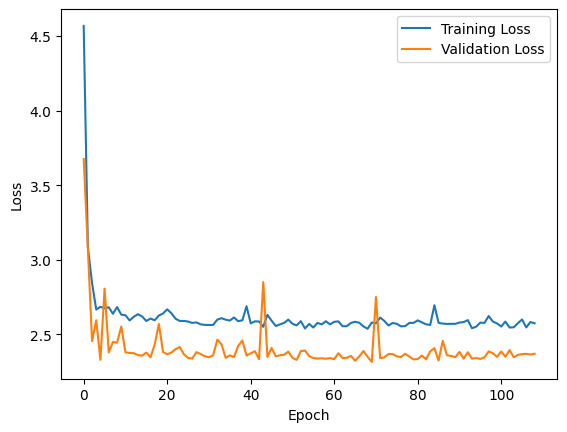

In [2]:
# Plot the loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [3]:
train_loss_history[0]

2.854262077680198

# detect.py

In [1]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
from model import EAST
import os
from dataset import get_rotate_mat
import numpy as np
import lanms


def resize_img(img):
    """resize image to be divisible by 32"""
    w, h = img.size
    resize_w = w
    resize_h = h

    resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
    resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
    img = img.resize((resize_w, resize_h), Image.BILINEAR)
    ratio_h = resize_h / h
    ratio_w = resize_w / w

    return img, ratio_h, ratio_w


def load_pil(img):
    """convert PIL Image to torch.Tensor"""
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ]
    )
    return t(img).unsqueeze(0)


def is_valid_poly(res, score_shape, scale):
    """check if the poly in image scope
    Input:
            res        : restored poly in original image
            score_shape: score map shape
            scale      : feature map -> image
    Output:
            True if valid
    """
    cnt = 0
    for i in range(res.shape[1]):
        if (
            res[0, i] < 0
            or res[0, i] >= score_shape[1] * scale
            or res[1, i] < 0
            or res[1, i] >= score_shape[0] * scale
        ):
            cnt += 1
    return True if cnt <= 1 else False


def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
    """restore polys from feature maps in given positions
    Input:
            valid_pos  : potential text positions <numpy.ndarray, (n,2)>
            valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
            score_shape: shape of score map
            scale      : image / feature map
    Output:
            restored polys <numpy.ndarray, (n,8)>, index
    """
    polys = []
    index = []
    valid_pos *= scale
    d = valid_geo[:4, :]  # 4 x N
    angle = valid_geo[4, :]  # N,

    for i in range(valid_pos.shape[0]):
        x = valid_pos[i, 0]
        y = valid_pos[i, 1]
        y_min = y - d[0, i]
        y_max = y + d[1, i]
        x_min = x - d[2, i]
        x_max = x + d[3, i]
        rotate_mat = get_rotate_mat(-angle[i])

        temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
        temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
        coordidates = np.concatenate((temp_x, temp_y), axis=0)
        res = np.dot(rotate_mat, coordidates)
        res[0, :] += x
        res[1, :] += y

        if is_valid_poly(res, score_shape, scale):
            index.append(i)
            polys.append(
                [
                    res[0, 0],
                    res[1, 0],
                    res[0, 1],
                    res[1, 1],
                    res[0, 2],
                    res[1, 2],
                    res[0, 3],
                    res[1, 3],
                ]
            )
    return np.array(polys), index


def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
    """get boxes from feature map
    Input:
            score       : score map from model <numpy.ndarray, (1,row,col)>
            geo         : geo map from model <numpy.ndarray, (5,row,col)>
            score_thresh: threshold to segment score map
            nms_thresh  : threshold in nms
    Output:
            boxes       : final polys <numpy.ndarray, (n,9)>
    """
    score = score[0, :, :]
    xy_text = np.argwhere(score > score_thresh)  # n x 2, format is [r, c]
    if xy_text.size == 0:
        return None

    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    valid_pos = xy_text[:, ::-1].copy()  # n x 2, [x, y]
    valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]]  # 5 x n
    polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape)
    if polys_restored.size == 0:
        return None

    boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = polys_restored
    boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
    print(np.max(boxes[:, 8]))
    boxes = lanms.merge_quadrangle_n9(boxes.astype("float32"), nms_thresh)
    print(np.max(boxes[:, 8]))
    return boxes


def adjust_ratio(boxes, ratio_w, ratio_h):
    """refine boxes
    Input:
            boxes  : detected polys <numpy.ndarray, (n,9)>
            ratio_w: ratio of width
            ratio_h: ratio of height
    Output:
            refined boxes
    """
    if boxes is None or boxes.size == 0:
        return None
    boxes[:, [0, 2, 4, 6]] /= ratio_w
    boxes[:, [1, 3, 5, 7]] /= ratio_h
    return np.around(boxes)


def detect(img, model, device):
    """detect text regions of img using model
    Input:
            img   : PIL Image
            model : detection model
            device: gpu if gpu is available
    Output:
            detected polys
    """
    img, ratio_h, ratio_w = resize_img(img)
    with torch.no_grad():
        score, geo = model(load_pil(img).to(device))
    boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
    return adjust_ratio(boxes, ratio_w, ratio_h)


def plot_boxes(img, boxes):
    """plot boxes on image"""
    if boxes is None:
        return img

    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.polygon(
            [box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]],
            outline=(0, 255, 0),
        )
    return img


def detect_dataset(model, device, test_img_path, submit_path):
    """detection on whole dataset, save .txt results in submit_path
    Input:
            model        : detection model
            device       : gpu if gpu is available
            test_img_path: dataset path
            submit_path  : submit result for evaluation
    """
    img_files = os.listdir(test_img_path)
    img_files = sorted(
        [os.path.join(test_img_path, img_file) for img_file in img_files]
    )

    for i, img_file in enumerate(img_files):
        print("evaluating {} image".format(i), end="\r")
        boxes = detect(Image.open(img_file), model, device)
        seq = []
        if boxes is not None:
            seq.extend([",".join([str(int(b)) for b in box]) + "\n" for box in boxes])
        with open(
            os.path.join(
                submit_path, "res_" + os.path.basename(img_file).replace(".jpg", ".txt")
            ),
            "w",
        ) as f:
            f.writelines(seq)

make: Entering directory '/mnt/data1/src/ocr/EAST/lanms'
g++ -o adaptor.so -I include  -std=c++11 -O3 -I/usr/include/python3.10 -I/usr/include/python3.10  -Wno-unused-result -Wsign-compare -g      -fstack-protector-strong -Wformat -Werror=format-security  -DNDEBUG -g -fwrapv -O2 -Wall -L/usr/lib/python3.10/config-3.10-x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu  -lcrypt -ldl  -lm -lm  adaptor.cpp include/clipper/clipper.cpp --shared -fPIC


In file included from include/pybind11/pytypes.h:12,
                 from include/pybind11/cast.h:13,
                 from include/pybind11/attr.h:13,
                 from include/pybind11/pybind11.h:43,
                 from adaptor.cpp:1:
include/pybind11/common.h:491:33: warning: ‘int PyThread_create_key()’ is deprecated [-Wdeprecated-declarations]
  491 |     decltype(PyThread_create_key()) tstate = 0; // Usually an int but a long on Cygwin64 with Python 3.x
      |              ~~~~~~~~~~~~~~~~~~~^~
In file included from /usr/include/python3.10/Python.h:122,
                 from include/pybind11/common.h:100,
                 from include/pybind11/pytypes.h:12,
                 from include/pybind11/cast.h:13,
                 from include/pybind11/attr.h:13,
                 from include/pybind11/pybind11.h:43,
                 from adaptor.cpp:1:
/usr/include/python3.10/pythread.h:108:36: note: declared here
  108 | Py_DEPRECATED(3.7) PyAPI_FUNC(int) PyThread_create_key(void

make: Leaving directory '/mnt/data1/src/ocr/EAST/lanms'


In [2]:
img_path = "/mnt/data1/src/ocr/vinai-vietnamese/test_img/im1501.jpg"
# model_path = "./pths/vinai-vietnamese/600.pth"
model_path = "/mnt/data1/src/ocr/EAST/pths/east_vgg16.pth"
res_img = "./res.bmp"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
img = Image.open(img_path)

boxes = detect(img, model, device)
# plot_img = plot_boxes(img, boxes)
# plot_img.save(res_img)

1.0
1.0
